#Date 2021.11.12

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def generator(N, m):
    """
    generate the network
    :param N: number of nodes
    :param m: new node has m links
    :return:
    """

    # randomly generate the C and D
    identity = np.ones(N, dtype=int)
    Cs = np.random.choice(N, N//2, replace=False)
    for i in Cs:
        identity[i] =  0 # 0 - C, 1 - D


    # generate a BA network with 4000 nodes and <k> = 2m = 4
    ba = nx.barabasi_albert_graph(N, m, seed=666)

    # nodes
    nodes = [i for i in range(N)]

    # get the neighbours for each vert [(0, [1, 2]), (1, [0, 3]), (2, [0, 3]), (3, [1, 2])]
    adj = [(n, list(nbrdict.keys())) for n, nbrdict in ba.adjacency()]
    # get the degrees [(0, [1, 2]), (1, [0, 3]), (2, [0, 3]), (3, [1, 2])]
    degrees = list(ba.degree())

    # randomly generate the C and D
    # 0 - C, 1 - D

    # ids = dict()
    # for i in range(N):
    #     ids[i] = identity[i]
    return ba, adj, identity, degrees, nodes
ba, adj, identity, degrees, nodes = generator(4000, 2)

Shows the original graph

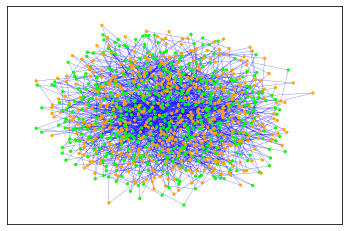

In [19]:
def update_color(identity):
    color = []
    for id_ in identity:
        if id_ == 0:
            color.append('#FFA500')  # orange for C
        else:
            color.append('#00FF00')  # green for D
    return color


color = update_color(identity)


nx.draw_networkx(ba, node_size=5, node_color=color, with_labels=False, width=0.2, edge_color='b')
plt.show()



In [3]:
def cal_gain(node, b):
    """
    calculate gain for the given node
    :param node: the node i
    """
    neighbours = adj[node][1]
    gain = 0
    idi = identity[node]
    for n in neighbours:
        idj = identity[n]
        if idi == idj and idi == 0:
            gain += 1
        elif idi == 1 and idj == 0:
            gain += b
    return gain

def update(nodei, nodej, b, gains, records):
    """
    compare nodei's gain with its neighbour nodej, and find out
    how to udpate nodei's od
    :param records: records of the numebr of pc, pd, f
    :param nodei: nodei
    :param nodej: nodej
    :return:
    """
    pc = records[0]
    pd = records[1]
    f = records[2]
    if gains[nodei] < gains[nodej]:
        beta = 1 / (max(degrees[nodei][1], degrees[nodei][1])*b)
        dice = np.random.rand()
        # dice <= beta means accept
        if dice <= beta:
            idi = identity[nodei]
            idj = identity[nodej]
            # if i and j have different id and i will change
            if idi != idj:
                if  idi == 0:
                    pc[nodei] = 0
                elif idi == 1:
                    pd[nodei] = 0
                f[nodei] = 1
            identity[nodei] = identity[nodej]

def choose_neighbor(nodei):
    """
    choose the node j for the node compare the gain
    :param nodei: the node we need to find a neighbour for
    :return: the neighbour chosen randomly
    """
    neighbors = adj[nodei][1]
    dice = np.random.randint(0, len(neighbors))
    return neighbors[dice]

In [4]:
# generate the b values
# bs = np.arange(1.2, 2.5, 0.1)
bs = np.arange(1, 1.3, 0.1)
# transient time
t0 = 500
# get steady
t1 = 1000
# after steady
ts = 10000

N = 4000
m = 2


In [78]:
# test code for the functions functional test
import time
# try once
s = time.time()
b = 2.2
for i in range(t1):
    # calculate gain
    gains = dict()
    for node in nodes:
        gains[node] = cal_gain(node, b)
    # update
    for node in nodes:
        nodej = choose_neighbor(node)
        update(node, nodej, b, gains)
end = time.time()
print(f"The time for {N} nodes to train {t1} time is {end - s}s")


The time for 4000 nodes to train 1000 time is 21.919710159301758s


In [79]:
count = 0
np.sum(identity)

3341

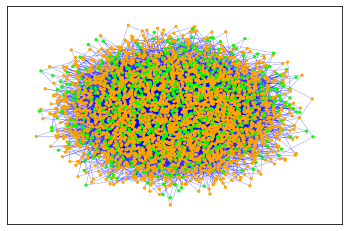

In [53]:
color = update_color(identity)
nx.draw_networkx(ba, node_size=5, node_color=color, with_labels=False, width=0.2, edge_color='b')
plt.show()


In [92]:
# record the <c> for each b
c_means = []
# record for the number of PC
pcs = []
# record for the number of PD
pds = []
# record for the number of F
fs = []

s_all = time.time()
for b in bs:
    sb = time.time()
    # generate the graph
    ba, adj, identity, degrees, nodes = generator(N, m)
    # pc, pd, f will all have N elements
    # if born as c or d, in pc, pd the elements on the same pos will be 1, 0 otherwise
    # if change id, the pos in f will be 1
    # calculate the sum of these list will give the number of node in these classes
    pc = np.zeros(N)
    pd = np.zeros(N)
    f = np.zeros(N)
    for node in range(N):
        if identity[node] == 0:
            pc[node] = 1
        else:
            pd[node] = 1
    records = [pc, pd, f]
    # pre-evo
    for t in range(t0):
        # calculate gain
        gains = dict()
        for node in nodes:
            gains[node] = cal_gain(node, b)
        # update
        for node in nodes:
            nodej = choose_neighbor(node)
            update(node, nodej, b, gains, records)

    # get steady
    key = True
    for t in range(t1):
        oldc = N - np.sum(identity)
        # calculate gain
        gains = dict()
        for node in nodes:
            gains[node] = cal_gain(node, b)
        # update
        for node in nodes:
            nodej = choose_neighbor(node)
            update(node, nodej, b, gains, records)
        newc = N - np.sum(identity)
        # find out reach steady state or not
        if key:
            if abs(newc - oldc) < 1/np.sqrt(N):
                print(f'we have reached the steady state after {t} times evolution.')
                key = False
    eb = time.time()
    c_means.append((N - np.sum(identity))/N)
    pcs.append(np.sum(records[0]))
    pds.append(np.sum(records[1]))
    fs.append(np.sum(records[2]))
    print(f'The time we used for b = {b} is {eb-sb}s.')
ea = time.time()
print(f'The time we used for all bs is {s_all-ea}s.')

we have reached the steady state after 21 times evolution.
The time we used for b = 1.2 is 34.54018211364746s.
we have reached the steady state after 2 times evolution.
The time we used for b = 1.3 is 35.708301067352295s.
we have reached the steady state after 5 times evolution.
The time we used for b = 1.4000000000000001 is 35.76573991775513s.
we have reached the steady state after 15 times evolution.
The time we used for b = 1.5000000000000002 is 38.01864767074585s.
we have reached the steady state after 66 times evolution.
The time we used for b = 1.6000000000000003 is 35.06501626968384s.
we have reached the steady state after 30 times evolution.
The time we used for b = 1.7000000000000004 is 37.26531767845154s.
we have reached the steady state after 36 times evolution.
The time we used for b = 1.8000000000000005 is 35.615554094314575s.
we have reached the steady state after 22 times evolution.
The time we used for b = 1.9000000000000006 is 35.73608899116516s.
we have reached the st

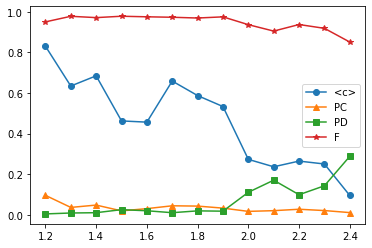

In [95]:
plt.plot(bs, c_means, 'o-', label='<c>')
plt.plot(bs, np.asarray(pcs)/2000, '^-', label='PC')
plt.plot(bs, np.asarray(pds)/2000, 's-', label='PD')
plt.plot(bs, np.asarray(fs)/N, '*-', label='F')
plt.legend()
plt.show()

In [17]:
def generator2(N, m, ks):
    """
    generate the network
    :param N: number of nodes
    :param m: new node has m links
    :return:
    """

    # generate a BA network with 4000 nodes and <k> = 2m = 4
    ba = nx.barabasi_albert_graph(N, m, seed=666)

    # nodes
    nodes = [i for i in range(N)]

    # get the neighbours for each vert [(0, [1, 2]), (1, [0, 3]), (2, [0, 3]), (3, [1, 2])]
    adj = [(n, list(nbrdict.keys())) for n, nbrdict in ba.adjacency()]
    # get the degrees [(0, [1, 2]), (1, [0, 3]), (2, [0, 3]), (3, [1, 2])]
    degrees = list(ba.degree())

    identity = np.ones(N, dtype=int)
    # based on the k threshold to asign C or D
    # k >= k* will be C, otherwise will be D
    for node in range(N):
        d = degrees[node][1]
        if d > ks:
            identity[node] = 0

    return ba, adj, identity, degrees, nodes


In [18]:
# record the curve of ct for different bs
ct_s = []
s_all = time.time()
for b in bs:
    sb = time.time()
    # generate the graph
    ba, adj, identity, degrees, nodes = generator2(N, m, 3)
    # pc, pd, f will all have N elements
    # if born as c or d, in pc, pd the elements on the same pos will be 1, 0 otherwise
    # if change id, the pos in f will be 1
    # calculate the sum of these list will give the number of node in these classes
    pc = np.zeros(N)
    pd = np.zeros(N)
    f = np.zeros(N)

    c = []

    for node in range(N):
        if identity[node] == 0:
            pc[node] = 1
        else:
            pd[node] = 1
    records = [pc, pd, f]
    # pre-evo
    for t in range(t0):
        # calculate gain
        gains = dict()
        for node in nodes:
            gains[node] = cal_gain(node, b)
        # update
        for node in nodes:
            nodej = choose_neighbor(node)
            update(node, nodej, b, gains, records)
        c.append((N - np.sum(identity))/N)    

    # get steady
    key = True
    for t in range(t1):
        oldc = N - np.sum(identity)
        # calculate gain
        gains = dict()
        for node in nodes:
            gains[node] = cal_gain(node, b)
        # update
        for node in nodes:
            nodej = choose_neighbor(node)
            update(node, nodej, b, gains, records)
        newc = N - np.sum(identity)
        # find out reach steady state or not
        if key:
            if abs(newc - oldc) < 1/np.sqrt(N):
                print(f'we have reached the steady state after {t} times evolution.')
                key = False
        c.append((N - np.sum(identity))/N)  
    eb = time.time()
    ct_s.append(c)
    # c_means.append((N - np.sum(identity))/N)
    # pcs.append(np.sum(records[0]))
    # pds.append(np.sum(records[1]))
    # fs.append(np.sum(records[2]))
    print(f'The time we used for b = {b} is {eb-sb}s.')
ea = time.time()
print(f'The time we used for all bs is {ea - s_all}s.')

we have reached the steady state after 5 times evolution.
The time we used for b = 1.0 is 35.906405210494995s.
we have reached the steady state after 0 times evolution.
The time we used for b = 1.1 is 35.700679063797s.
we have reached the steady state after 2 times evolution.
The time we used for b = 1.2000000000000002 is 35.688947916030884s.
we have reached the steady state after 4 times evolution.
The time we used for b = 1.3000000000000003 is 35.624977827072144s.
The time we used for all bs is 142.92199993133545s.


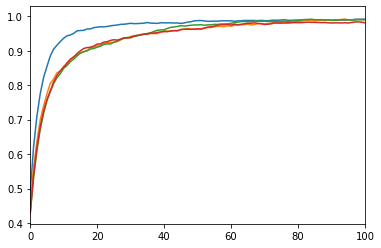

In [21]:
ts = [t for t in range(t0+t1)]
for c in ct_s:  
    plt.plot(ts, c)
plt.xlim(0, 100)
plt.show()